# FIAP Bootcamp - Wtec Suprimentos - Análise de Risco
Case: **Wtec Suprimentos - Análise de Crédito**\
Turma: **1IAR**

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| Claudio Manuel           | RM 346353      | 1IAR |
| Jonas Zarpellon          | RM 345724      | 1IAR |
| Rafael Yuji              | RM 346108      | 1IAR |

## Introdução

### Problema Proposto - Parte 4-A: Análise de Risco
- A empresa deseja, entre outras coisas, criar um 'robö automatizado' (na linguagem da propria empresa), que realize uma recomendacäo de crédito para que os analistas se baseiem nessa recomendacäo para conceder o limite måximo de crédito.
- Vale salientar que por se tratar de valores monetérios é importante que este modelo tenha um bom desempenho

### Abordagem Proposta
- O objetivo desta modelagem é treinar um algoritmo de aprendizado capaz de estimar o fator de risco em um cliente na forma de um percentual
- Será utilizado um algoritmo supervisionado para essa regressão, baseado nos fatores de risco atribuidos aos clientes na base de dados histórica
- Será explorada somente a hipótese 2, utilizando as informações disponíveis nas documentações contábeis

### Setup

In [1]:
# dados / io
import pandas as pd
import pandas_flavor as pf
import numpy as np
import joblib
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# otimização
from sklearnex import patch_sklearn
patch_sklearn()
# preprocessamento
from sklearn.preprocessing import StandardScaler
# machine learning
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# seleção de modelos
import optuna as opt
opt.logging.set_verbosity(opt.logging.WARNING)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
# display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=opt.exceptions.ExperimentalWarning)
pd.options.display.float_format = '{:,.4f}'.format


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Carga de Dados

In [2]:
data = pd.read_csv('solicitacoescredito_segmentada.csv')
data.sample(5).T

,2676,4664,5116,5583,5465
numero_solicitacao,"2,749.0000","4,737.0000","5,189.0000","5,656.0000","5,538.0000"
razaoSocial,Douglas Wong,Caroline Wright,Kathleen Summers,Ashley Johnson,Jamie Gregory-Rees
nomeFantasia,Mathew Watson,Elaine Bray-Chapman,Tracey Thomas-Taylor,Connor Cox,Joel Evans
cnpjSemTraco,JPXB50512133545813,QXUE06615581358861,LYXE74659784406683,BTXK71717619669732,SXQL48789557445419
maiorAtraso,5,12,2,17,16
margemBrutaAcumulada,0.6050,0.5512,0.2764,0.3947,0.6388
percentualProtestos,0.0000,0.0000,0.0000,0.0000,0.0000
primeiraCompra,2010-02-03T00:00:00,2020-05-12T00:00:00,2020-09-11T00:00:00,2007-10-11T00:00:00,2018-07-25T00:00:00
prazoMedioRecebimentoVendas,0,78,0,25,23
titulosEmAberto,0.0000,"26,922.9900",0.0000,"771,227.8300","7,000.0000"


### Pre-Processamento

#### filtro

In [3]:
# filtra as solicitações aprovadas
@pf.register_dataframe_method
def filter_status(
	data: pd.DataFrame, # dataframe com a coluna 'status'
	) -> pd.DataFrame:
	X = data.copy()
	X = X[X.status.isin(['AprovadoAnalista', 'AprovadoComite'])]
	X = X[X.anoFundacao > 1900]
	X = X[X.faturamentoBruto > 0]
	X = X[X.periodoDemonstrativoEmMeses > 0]
	X = X[X.cluster.notna()]
	return X
data.filter_status().describe().T

,count,mean,std,min,25%,50%,75%,max
numero_solicitacao,"6,631.0000","4,758.0694","2,537.8171",1.0000,"2,676.5000","4,853.0000","6,945.5000","9,034.0000"
maiorAtraso,"6,631.0000",23.8928,63.8380,0.0000,3.0000,6.0000,21.0000,977.0000
margemBrutaAcumulada,"6,631.0000",0.3734,0.1950,0.0000,0.2992,0.4123,0.5123,1.0000
percentualProtestos,"5,645.0000",0.0155,0.5805,0.0000,0.0000,0.0000,0.0000,36.9837
prazoMedioRecebimentoVendas,"6,631.0000",23.5955,65.7878,0.0000,0.0000,0.0000,32.0000,"1,605.0000"
titulosEmAberto,"6,631.0000","52,147.3565","186,770.4664",0.0000,0.0000,0.0000,"17,352.2400","2,836,656.0000"
valorSolicitado,"6,631.0000","272,351.1101","7,380,328.6783","3,000.0000","25,000.0000","50,000.0000","100,000.0000","600,000,000.0000"
diferencaPercentualRisco,"6,631.0000",0.7412,0.1251,0.2642,0.6604,0.7500,0.8491,1.0000
percentualRisco,"6,631.0000",0.2588,0.1251,0.0000,0.1509,0.2500,0.3396,0.7358
dashboardCorrelacao,"6,631.0000",0.0425,0.4915,-1.0000,0.0000,0.0000,0.0000,0.9999


#### feature engineering

In [4]:
# gera as features calculadas sem usar as colunas de documentação
@pf.register_dataframe_method
def engineer(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	X['faturamentoMensal'] = X.faturamentoBruto / X.periodoDemonstrativoEmMeses
	X['margemMensal'] = X.margemBruta / X.periodoDemonstrativoEmMeses
	X['margem_percentual'] = (X.margemMensal / X.faturamentoMensal).replace([np.inf, np.NINF], np.nan)
	X['dt_dataAprovadoNivelAnalista'] = pd.to_datetime(X.dataAprovadoNivelAnalista, errors='coerce')
	X['dt_primeiraCompra'] = pd.to_datetime(X.primeiraCompra, errors='coerce')
	X['tempoPrimeiraCompra'] = (X.dt_dataAprovadoNivelAnalista - X.dt_primeiraCompra).dt.days
	return X

data.filter_status().engineer().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6631 entries, 0 to 8961
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   numero_solicitacao            6631 non-null   float64       
 1   razaoSocial                   6631 non-null   object        
 2   nomeFantasia                  6631 non-null   object        
 3   cnpjSemTraco                  6631 non-null   object        
 4   maiorAtraso                   6631 non-null   int64         
 5   margemBrutaAcumulada          6631 non-null   float64       
 6   percentualProtestos           5645 non-null   float64       
 7   primeiraCompra                6631 non-null   object        
 8   prazoMedioRecebimentoVendas   6631 non-null   int64         
 9   titulosEmAberto               6631 non-null   float64       
 10  valorSolicitado               6631 non-null   float64       
 11  status                        

#### seleção de features

In [5]:
# seleciona as features relevantes
@pf.register_dataframe_method
def select(
  data: pd.DataFrame,
  identifier: bool = False,
) -> pd.DataFrame:
	X = data.copy()
	keep = [
			'percentualRisco',
			# 'valorAprovado',
			# 'limiteEmpresaAnaliseCredito',
			# 'limiteCredito',
			'faturamentoMensal',
			'maiorAtraso',
			'tempoPrimeiraCompra',
			'prazoMedioRecebimentoVendas',
			'anoFundacao',
			'restricoes',
			'empresa_MeEppMei',
			'scorePontualidade',
			'margem_percentual',
			'cluster',
		]
	if identifier:
		keep = keep + ['numero_solicitacao']
	intersection = list(set(data.columns).intersection(set(keep)))
	return X[intersection]
data.filter_status().engineer().select().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6631 entries, 0 to 8961
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   anoFundacao                  6631 non-null   float64
 1   percentualRisco              6631 non-null   float64
 2   prazoMedioRecebimentoVendas  6631 non-null   int64  
 3   scorePontualidade            6631 non-null   float64
 4   tempoPrimeiraCompra          6631 non-null   int64  
 5   maiorAtraso                  6631 non-null   int64  
 6   faturamentoMensal            6631 non-null   float64
 7   restricoes                   6631 non-null   object 
 8   cluster                      6631 non-null   float64
 9   empresa_MeEppMei             6631 non-null   object 
 10  margem_percentual            6631 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 621.7+ KB


#### encoding das categorias

⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
a segmentação de clientes previamente obtida será utilizada no treinamento dos modelos. A feature é categórica e deve ser codificada com one-hot-encoding.
</td></tr></table></div>

In [6]:
# realiza o one-hot encoding do cluster
@pf.register_dataframe_method
def encode(
		data: pd.DataFrame,
		features: list,
		) -> pd.DataFrame:
	X = data.copy()
	for feature in features:
		X = pd.get_dummies(X[feature], prefix=feature).join(X)
		X = X.drop(columns=[feature])
	return X
data.filter_status().engineer().select().encode(['cluster']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6631 entries, 0 to 8961
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster_0.0                  6631 non-null   uint8  
 1   cluster_1.0                  6631 non-null   uint8  
 2   cluster_2.0                  6631 non-null   uint8  
 3   cluster_3.0                  6631 non-null   uint8  
 4   cluster_4.0                  6631 non-null   uint8  
 5   cluster_5.0                  6631 non-null   uint8  
 6   anoFundacao                  6631 non-null   float64
 7   percentualRisco              6631 non-null   float64
 8   prazoMedioRecebimentoVendas  6631 non-null   int64  
 9   scorePontualidade            6631 non-null   float64
 10  tempoPrimeiraCompra          6631 non-null   int64  
 11  maiorAtraso                  6631 non-null   int64  
 12  faturamentoMensal            6631 non-null   float64
 13  restricoes        

#### data types

In [7]:
# converte data types
@pf.register_dataframe_method
def type_cast(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	X = X.astype('float32')		
	return X
data.filter_status().engineer().select().encode(['cluster']).type_cast().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6631 entries, 0 to 8961
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster_0.0                  6631 non-null   float32
 1   cluster_1.0                  6631 non-null   float32
 2   cluster_2.0                  6631 non-null   float32
 3   cluster_3.0                  6631 non-null   float32
 4   cluster_4.0                  6631 non-null   float32
 5   cluster_5.0                  6631 non-null   float32
 6   anoFundacao                  6631 non-null   float32
 7   percentualRisco              6631 non-null   float32
 8   prazoMedioRecebimentoVendas  6631 non-null   float32
 9   scorePontualidade            6631 non-null   float32
 10  tempoPrimeiraCompra          6631 non-null   float32
 11  maiorAtraso                  6631 non-null   float32
 12  faturamentoMensal            6631 non-null   float32
 13  restricoes        

#### limpeza

In [8]:
# elimina valores nulos
@pf.register_dataframe_method
def clean(
  data: pd.DataFrame,
) -> pd.DataFrame:
	return data.dropna()
data.filter_status().engineer().select().encode(['cluster']).type_cast().clean().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6631 entries, 0 to 8961
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster_0.0                  6631 non-null   float32
 1   cluster_1.0                  6631 non-null   float32
 2   cluster_2.0                  6631 non-null   float32
 3   cluster_3.0                  6631 non-null   float32
 4   cluster_4.0                  6631 non-null   float32
 5   cluster_5.0                  6631 non-null   float32
 6   anoFundacao                  6631 non-null   float32
 7   percentualRisco              6631 non-null   float32
 8   prazoMedioRecebimentoVendas  6631 non-null   float32
 9   scorePontualidade            6631 non-null   float32
 10  tempoPrimeiraCompra          6631 non-null   float32
 11  maiorAtraso                  6631 non-null   float32
 12  faturamentoMensal            6631 non-null   float32
 13  restricoes        

#### padronização

In [9]:
# aplica padronização por z-score
@pf.register_dataframe_method
def standardize(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	# clip outliers
	X = X.clip(lower=X.quantile(0.01), upper=X.quantile(0.99), axis=1)
	standardizer = StandardScaler()
	X = pd.DataFrame(standardizer.fit_transform(X), columns=X.columns)
	return X
data.filter_status().engineer().select().encode(['cluster']).type_cast().clean().standardize().describe().T

,count,mean,std,min,25%,50%,75%,max
cluster_0.0,"6,631.0000",-0.0000,1.0001,-1.0111,-1.0111,0.9891,0.9891,0.9891
cluster_1.0,"6,631.0000",0.0000,1.0001,-0.2417,-0.2417,-0.2417,-0.2417,4.1373
cluster_2.0,"6,631.0000",0.0000,1.0001,-0.6520,-0.6520,-0.6520,1.5337,1.5337
cluster_3.0,"6,631.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
cluster_4.0,"6,631.0000",-0.0000,1.0001,-0.2452,-0.2452,-0.2452,-0.2452,4.0787
cluster_5.0,"6,631.0000",0.0000,1.0001,-0.2965,-0.2965,-0.2965,-0.2965,3.3721
anoFundacao,"6,631.0000",0.0000,1.0001,-3.4070,-0.5660,0.2588,0.8087,1.1752
percentualRisco,"6,631.0000",-0.0000,1.0001,-1.7996,-0.8690,-0.0689,0.6550,2.5272
prazoMedioRecebimentoVendas,"6,631.0000",-0.0000,1.0001,-0.5146,-0.5146,-0.5146,0.2597,5.1965
scorePontualidade,"6,631.0000",-0.0000,1.0001,-2.2904,0.2915,0.4953,0.4953,0.4953


#### preparação dos dados

In [10]:
data_preprocess = data.filter_status().engineer().select().encode(['cluster']).type_cast().clean()
targets_preprocess = data_preprocess['percentualRisco']
features_preprocess = data_preprocess.drop(columns=['percentualRisco']).standardize()

data_train, data_test, targets_train, targets_test = train_test_split(features_preprocess, targets_preprocess, test_size=0.2, random_state=42)

display(data_train.info())
display(data_train.describe().T)
print (f'Shape de data_train: {data_train.shape}')
print (f'Shape de data_test: {data_test.shape}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5304 entries, 5165 to 860
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster_0.0                  5304 non-null   float64
 1   cluster_1.0                  5304 non-null   float64
 2   cluster_2.0                  5304 non-null   float64
 3   cluster_3.0                  5304 non-null   float64
 4   cluster_4.0                  5304 non-null   float64
 5   cluster_5.0                  5304 non-null   float64
 6   anoFundacao                  5304 non-null   float64
 7   prazoMedioRecebimentoVendas  5304 non-null   float64
 8   scorePontualidade            5304 non-null   float64
 9   tempoPrimeiraCompra          5304 non-null   float64
 10  maiorAtraso                  5304 non-null   float64
 11  faturamentoMensal            5304 non-null   float64
 12  restricoes                   5304 non-null   float64
 13  empresa_MeEppMei

None

,count,mean,std,min,25%,50%,75%,max
cluster_0.0,"5,304.0000",0.0124,0.9999,-1.0111,-1.0111,0.9891,0.9891,0.9891
cluster_1.0,"5,304.0000",-0.0031,0.9940,-0.2417,-0.2417,-0.2417,-0.2417,4.1373
cluster_2.0,"5,304.0000",-0.0062,0.9973,-0.6520,-0.6520,-0.6520,1.5337,1.5337
cluster_3.0,"5,304.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
cluster_4.0,"5,304.0000",-0.0104,0.9799,-0.2452,-0.2452,-0.2452,-0.2452,4.0787
cluster_5.0,"5,304.0000",-0.0005,0.9993,-0.2965,-0.2965,-0.2965,-0.2965,3.3721
anoFundacao,"5,304.0000",-0.0059,1.0067,-3.4070,-0.5660,0.2588,0.8087,1.1752
prazoMedioRecebimentoVendas,"5,304.0000",0.0048,1.0025,-0.5146,-0.5146,-0.5146,0.2597,5.1965
scorePontualidade,"5,304.0000",0.0064,0.9937,-2.2904,0.3130,0.4953,0.4953,0.4953
tempoPrimeiraCompra,"5,304.0000",0.0078,1.0060,-1.1870,-0.7808,-0.3096,0.6094,2.4259


Shape de data_train: (5304, 15)
Shape de data_test: (1327, 15)


### Treinamento dos Modelos

⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
- foram testados 3 algoritmos <br>
- para cada algoritmo, foram testadas as principais variações dos seus hiperparâmetros<br>
- a busca foi feita por otimização bayesiana, utilizando validação cruzada com 5 partições <br>
- todas as métricas de avaliação foram calculadas sobre o conjunto de teste (holdout) <br>
- o particionamento do conjunto de teste foi feito com 20% dos registros disponíveis
</td></tr></table></div>

#### rotinas de otimização

In [11]:
# callback para salvar o melhor modelo
def callback(
		study: opt.study.Study,
		trial: opt.trial.FrozenTrial,
	) -> None:
	if study.best_trial.number == trial.number:
		study.set_user_attr(key='best_estimator', value=trial.user_attrs['estimator'])

In [12]:
# plota os resultados da otimização e a avaliação do melhor modelo no dataset de teste
def plot_optimization_results(
		study: opt.study.Study,
		y_test: pd.DataFrame,
		y_pred: np.ndarray,
	) -> None:

	# plota os resultados da otimização
	display(opt.visualization.plot_optimization_history(study))
	try:
		display(opt.visualization.plot_param_importances(study))
	except:
		...
	
	# imprime o melhor modelo
	print (f'Best trial: {study.best_trial.value}')
	print (f'Best parameters: {study.best_params}')

In [13]:
# rotina de otimização bayesiana
def optimize(
		objective, #Callable,
    description: str,
    n_trials: int,
		X: pd.DataFrame,
		y: pd.DataFrame,
		X_test: pd.DataFrame,
		y_test: pd.DataFrame,
	) -> dict: 
        
	# cria o estudo e executa a otimização
	study = opt.create_study(direction='maximize')
	study.optimize(lambda trial:objective(trial, X, y),
		callbacks=[callback], n_trials=n_trials, timeout=60*5, n_jobs=-1, show_progress_bar = True)

	# fita e salva o melhor modelo
	fit = study.user_attrs['best_estimator'].fit(X, y)
	joblib.dump(fit, f'models/{description}.joblib')

	# avalia os resultados no conjunto de teste
	y_pred_val = fit.predict(X)
	y_pred = fit.predict(X_test)
	metrics = {
		'validation': {
			'mae': mean_absolute_error(y, y_pred_val),
			'rmse': np.sqrt(mean_squared_error(y, y_pred_val)),
			'r2': r2_score(y, y_pred_val),
			# 'mape': mean_absolute_percentage_error(y, y_pred_val),
		},
		'test': {
			'mae': mean_absolute_error(y_test, y_pred),
			'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
			'r2': r2_score(y_test, y_pred),
			# 'mape': mean_absolute_percentage_error(y_test, y_pred),
		}
	}
	validation = pd.DataFrame(metrics['validation'], index=['validation'])
	test = pd.DataFrame(metrics['test'], index=['test'])
	display(pd.concat([validation, test], axis=0).T)

	# plota os resultados
	plot_optimization_results(study, y_test, y_pred)
	
	return {
		'description': description,
		'metrics': metrics,
		'estimator': fit,
		'results': study.trials_dataframe(),
		'predictions': y_pred,
	}


⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
o treinamento foi realizado com o objetivo de minimizar o RMSE
</td></tr></table></div>

#### elasticnet

In [14]:
# define o espaço de busca e a função objetivo
def objective_elasticnet(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:
	estimator = ElasticNet(
		alpha=trial.suggest_loguniform('alpha', 1e-5, 1e-1),
		l1_ratio=trial.suggest_uniform('l1_ratio', 0.0, 1.0),
		fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
	)
	trial.set_user_attr(key='estimator', value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
	return score.mean()

np.seterr(divide='ignore', invalid='ignore')

# rotina de otimização bayesiana
elasticnet_model = optimize(
	objective=objective_elasticnet, 
	description='elasticnet_risk', n_trials=150,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

  0%|          | 0/150 [00:00<?, ?it/s]

,validation,test
mae,0.0732,0.0763
rmse,0.0910,0.0944
r2,0.4646,0.4535


Best trial: -0.09123963516753816
Best parameters: {'alpha': 1.7151596276830722e-05, 'l1_ratio': 0.43053560028592314, 'fit_intercept': True}


#### random forest

In [15]:
# define o espaço de busca e a função objetivo
def objective_random_forests(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:
	estimator = RandomForestRegressor(
		criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
		min_samples_split = trial.suggest_int('min_samples_split', 2, 100),
		min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100),
	)
	trial.set_user_attr(key='estimator', value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
	return score.mean()

np.seterr(divide='ignore', invalid='ignore')

# rotina de otimização bayesiana
random_forests_model = optimize(
	objective=objective_random_forests, 
	description='random_forests_risk', n_trials=100,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

  0%|          | 0/100 [00:00<?, ?it/s]

,validation,test
mae,0.0308,0.0409
rmse,0.0413,0.0547
r2,0.8899,0.8161


Best trial: -0.05540078832594468
Best parameters: {'criterion': 'squared_error', 'min_samples_split': 33, 'min_samples_leaf': 2}


#### xgboost - gbtree

In [16]:
# define o espaço de busca e a função objetivo
def xgboost_regressor_gbtree(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:
	hyperparameters = {
		# 'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
		'booster': 'gbtree',
		'objective': 'reg:squarederror',
		'eval_metric': 'rmse',
		'verbosity': 0,
		'alpha': trial.suggest_float('alpha', 1e-3, 1, log=True),
		'lambda': trial.suggest_float('lambda', 1e-3, 1, log=True),
		'eta': trial.suggest_float('eta', 1e-10, 1.0, log=True),
		'max_depth': trial.suggest_int('max_depth', 1, 9),
		'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
		'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
		'gamma': trial.suggest_float('gamma', 1e-8, 1e8, log=True),
		'sample_type': trial.suggest_categorical('sample_type', ['uniform', 'weighted']),
		'normalize_type': trial.suggest_categorical('normalize_type', ['tree', 'forest']),
		'rate_drop': trial.suggest_float('rate_drop', 1e-8, 1.0, log=True),
		'skip_drop': trial.suggest_float('skip_drop', 1e-8, 1.0, log=True),
		'updater': trial.suggest_categorical('updater', ['coord_descent', 'shotgun']),
		'feature_selector': trial.suggest_categorical('feature_selector', ['cyclic', 'shuffle']),
	}
	hp = {
		'booster': hyperparameters['booster'],
		'objective': hyperparameters['objective'],
		'eval_metric': hyperparameters['eval_metric'],
		'verbosity': hyperparameters['verbosity'],
	}
	
	if hyperparameters['booster'] in ['gbtree', 'dart']:
		# L1 regularization term on weights. Increasing this value will make model more conservative.
		hp['alpha'] = hyperparameters['alpha']
		# L2 regularization term on weights. Increasing this value will make model more conservative.
		hp['lambda'] = hyperparameters['lambda']
		# Step size shrinkage used in update to prevents overfitting
		hp['eta'] = hyperparameters['eta']
		# maximum depth of the tree, signifies complexity of the tree.
		hp['max_depth'] = hyperparameters['max_depth']
		# Controls a way new nodes are added to the tree.
		hp['grow_policy'] = hyperparameters['grow_policy']
		# minimum child weight, larger the term more conservative the tree.
		hp['min_child_weight'] = hyperparameters['min_child_weight']
		# defines how conservative algorithm is.
		hp['gamma'] = hyperparameters['gamma']

	if hyperparameters['booster'] == 'dart':
		# sampling ratio for dropout.
		hp['sample_type'] = hyperparameters['sample_type']
		# Type of normalization algorithm
		hp['normalize_type'] = hyperparameters['normalize_type']
		# Dropout rate (a fraction of previous trees to drop during the dropout)
		hp['rate_drop'] = hyperparameters['rate_drop']
		# Probability of skipping the dropout procedure during a boosting iteration.
		hp['skip_drop'] = hyperparameters['skip_drop']

	if hyperparameters['booster'] == 'gblinear':
		# algorithm to fit linear model
		hp['updater'] = hyperparameters['updater']
		# feature selector
		hp['feature_selector'] = hyperparameters['feature_selector']

	estimator = XGBRegressor(**hp)
	trial.set_user_attr(key='estimator', value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
	return score.mean()

np.seterr(divide='ignore', invalid='ignore')

# rotina de otimização bayesiana
xgboost_model_gbtree = optimize(
	objective=xgboost_regressor_gbtree, 
	description='xgboost_gbtree_risk', n_trials=100,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

  0%|          | 0/100 [00:00<?, ?it/s]

,validation,test
mae,0.0184,0.0372
rmse,0.0255,0.0519
r2,0.9580,0.8348


Best trial: -0.05248424634337425
Best parameters: {'alpha': 0.0020523755428286513, 'lambda': 0.0017061113399300196, 'eta': 0.19610450384400085, 'max_depth': 7, 'grow_policy': 'lossguide', 'min_child_weight': 4, 'gamma': 1.2438126893652148e-06, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0006267369697353726, 'skip_drop': 0.00043426580555770385, 'updater': 'coord_descent', 'feature_selector': 'cyclic'}


#### xgboost - dart

In [17]:
# define o espaço de busca e a função objetivo
def xgboost_regressor_dart(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:
	hyperparameters = {
		# 'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
		'booster': 'dart',
		'objective': 'reg:squarederror',
		'eval_metric': 'rmse',
		'verbosity': 0,
		'alpha': trial.suggest_float('alpha', 1e-3, 1, log=True),
		'lambda': trial.suggest_float('lambda', 1e-3, 1, log=True),
		'eta': trial.suggest_float('eta', 1e-10, 1.0, log=True),
		'max_depth': trial.suggest_int('max_depth', 1, 9),
		'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
		'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
		'gamma': trial.suggest_float('gamma', 1e-8, 1e8, log=True),
		'sample_type': trial.suggest_categorical('sample_type', ['uniform', 'weighted']),
		'normalize_type': trial.suggest_categorical('normalize_type', ['tree', 'forest']),
		'rate_drop': trial.suggest_float('rate_drop', 1e-8, 1.0, log=True),
		'skip_drop': trial.suggest_float('skip_drop', 1e-8, 1.0, log=True),
		'updater': trial.suggest_categorical('updater', ['coord_descent', 'shotgun']),
		'feature_selector': trial.suggest_categorical('feature_selector', ['cyclic', 'shuffle']),
	}
	hp = {
		'booster': hyperparameters['booster'],
		'objective': hyperparameters['objective'],
		'eval_metric': hyperparameters['eval_metric'],
		'verbosity': hyperparameters['verbosity'],
	}
	
	if hyperparameters['booster'] in ['gbtree', 'dart']:
		# L1 regularization term on weights. Increasing this value will make model more conservative.
		hp['alpha'] = hyperparameters['alpha']
		# L2 regularization term on weights. Increasing this value will make model more conservative.
		hp['lambda'] = hyperparameters['lambda']
		# Step size shrinkage used in update to prevents overfitting
		hp['eta'] = hyperparameters['eta']
		# maximum depth of the tree, signifies complexity of the tree.
		hp['max_depth'] = hyperparameters['max_depth']
		# Controls a way new nodes are added to the tree.
		hp['grow_policy'] = hyperparameters['grow_policy']
		# minimum child weight, larger the term more conservative the tree.
		hp['min_child_weight'] = hyperparameters['min_child_weight']
		# defines how conservative algorithm is.
		hp['gamma'] = hyperparameters['gamma']

	if hyperparameters['booster'] == 'dart':
		# sampling ratio for dropout.
		hp['sample_type'] = hyperparameters['sample_type']
		# Type of normalization algorithm
		hp['normalize_type'] = hyperparameters['normalize_type']
		# Dropout rate (a fraction of previous trees to drop during the dropout)
		hp['rate_drop'] = hyperparameters['rate_drop']
		# Probability of skipping the dropout procedure during a boosting iteration.
		hp['skip_drop'] = hyperparameters['skip_drop']

	if hyperparameters['booster'] == 'gblinear':
		# algorithm to fit linear model
		hp['updater'] = hyperparameters['updater']
		# feature selector
		hp['feature_selector'] = hyperparameters['feature_selector']

	estimator = XGBRegressor(**hp)
	trial.set_user_attr(key='estimator', value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
	return score.mean()

np.seterr(divide='ignore', invalid='ignore')

# rotina de otimização bayesiana
xgboost_model_dart = optimize(
	objective=xgboost_regressor_dart, 
	description='xgboost_dart_risk', n_trials=100,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

  0%|          | 0/100 [00:00<?, ?it/s]

,validation,test
mae,0.0211,0.0371
rmse,0.0288,0.0509
r2,0.9463,0.8411


Best trial: -0.05219507664442062
Best parameters: {'alpha': 0.34270909851089043, 'lambda': 0.001469630009477514, 'eta': 0.20545025505460413, 'max_depth': 9, 'grow_policy': 'lossguide', 'min_child_weight': 6, 'gamma': 2.0529345416016826e-07, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00015521564088129025, 'skip_drop': 1.3973460543379167e-07, 'updater': 'coord_descent', 'feature_selector': 'shuffle'}


#### comparação de modelos

In [18]:
# plota a distribuição dos residuais
def plot_residuals_distribution (
		y_true: pd.DataFrame, 
		y_pred: pd.DataFrame, 
		title: str
	) -> None:
	fig, axs = plt.subplot_mosaic([ ['R', 'R', 'R', 'D']],	figsize=(16, 6), constrained_layout=True, sharey=True)
	plt.rcParams['figure.figsize'] = (16, 6)
	sns.residplot(x=y_true, y=y_pred, scatter_kws={'s':10, 'alpha':0.8, 'color':'grey'}, 
		lowess=True, line_kws={'lw':1, 'alpha': 1, 'color': 'red'}, label='prediction', ax=axs['R'])
	sns.distplot(y_true - y_pred, bins=20, kde=True, color='grey', label='prediction', ax=axs['D'], vertical=True)
	plt.suptitle('plot de residuos para ' + title)
	plt.xlabel('residuais')
	plt.ylabel('densidade')
	plt.legend()
	plt.show()

mae   rmse     r2
elasticnet_risk     validation 0.0732 0.0910 0.4646
                    test       0.0763 0.0944 0.4535
random_forests_risk validation 0.0308 0.0413 0.8899
                    test       0.0409 0.0547 0.8161
xgboost_gbtree_risk validation 0.0184 0.0255 0.9580
                    test       0.0372 0.0519 0.8348
xgboost_dart_risk   validation 0.0211 0.0288 0.9463
                    test       0.0371 0.0509 0.8411

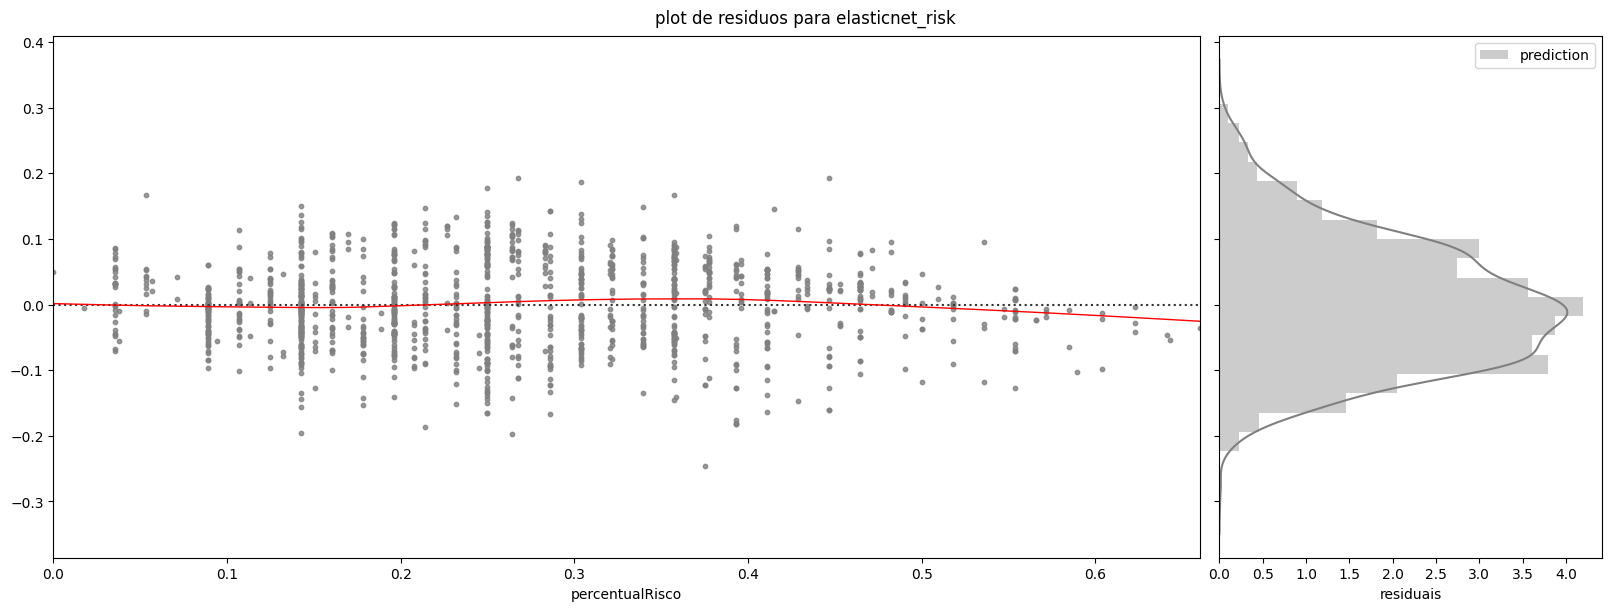

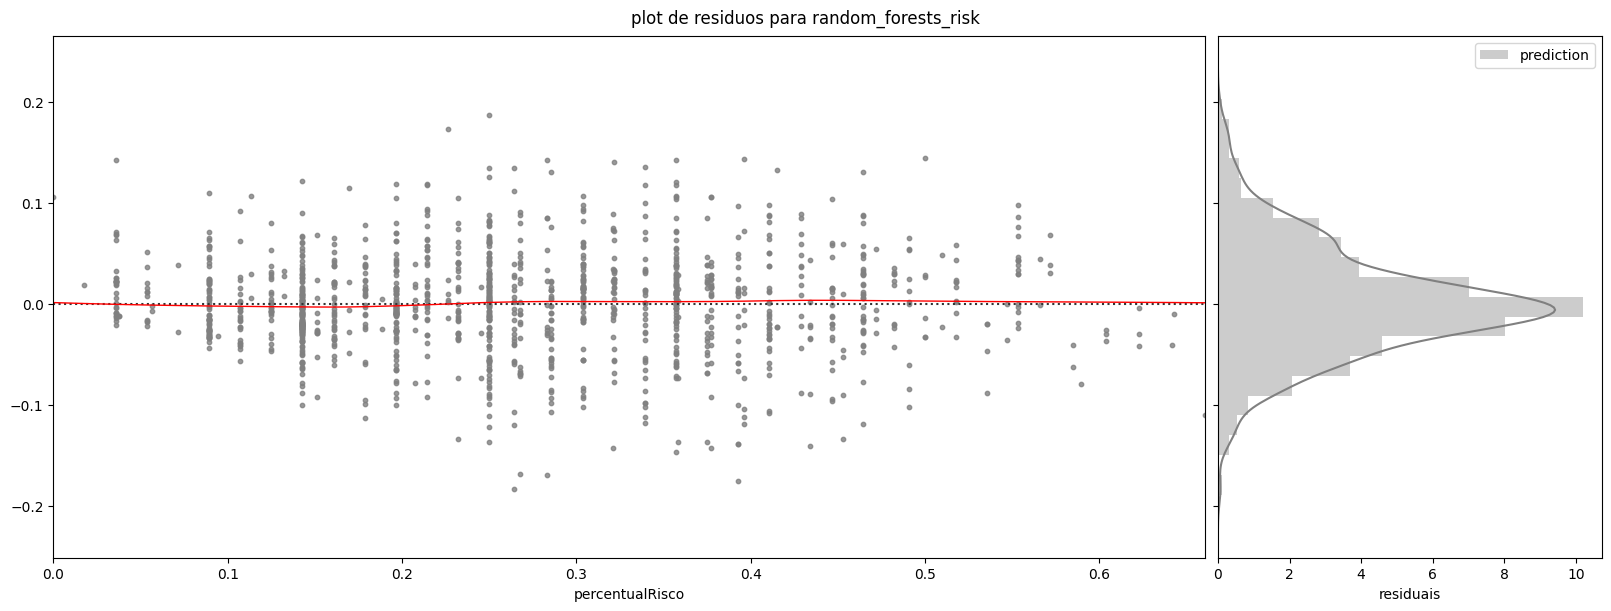

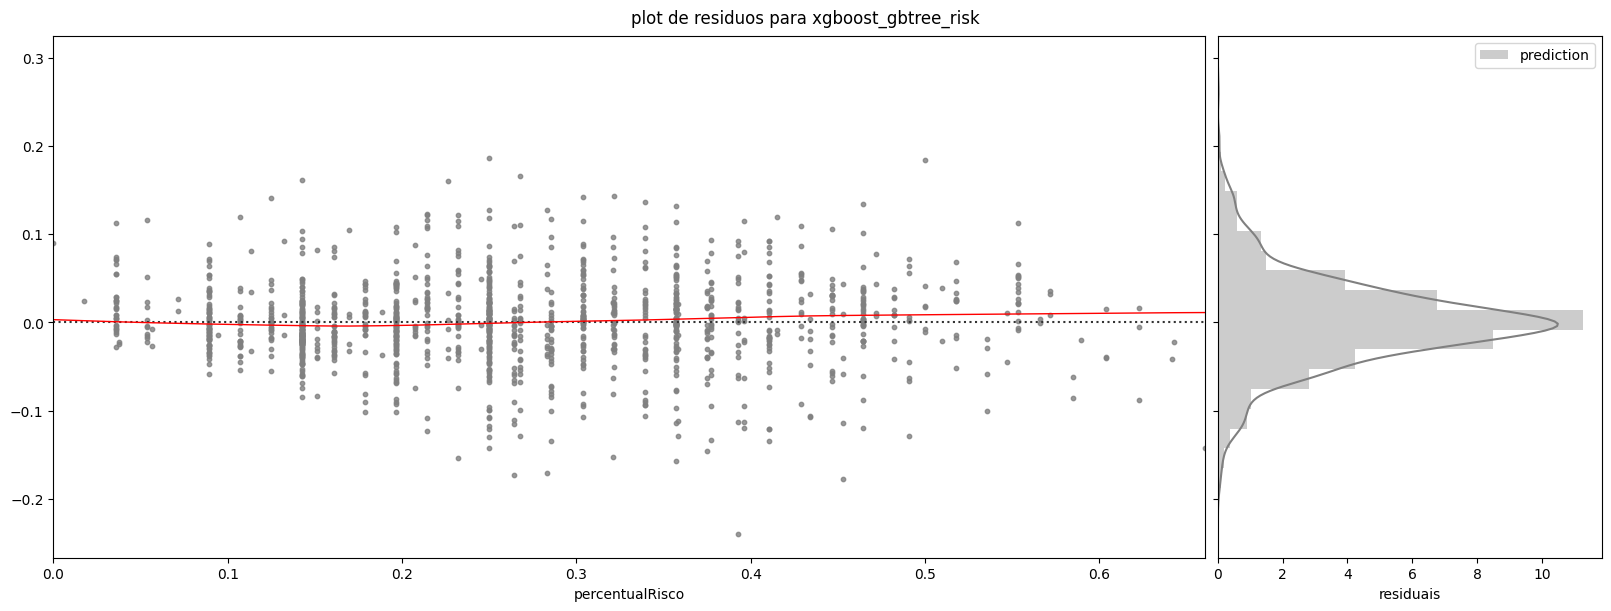

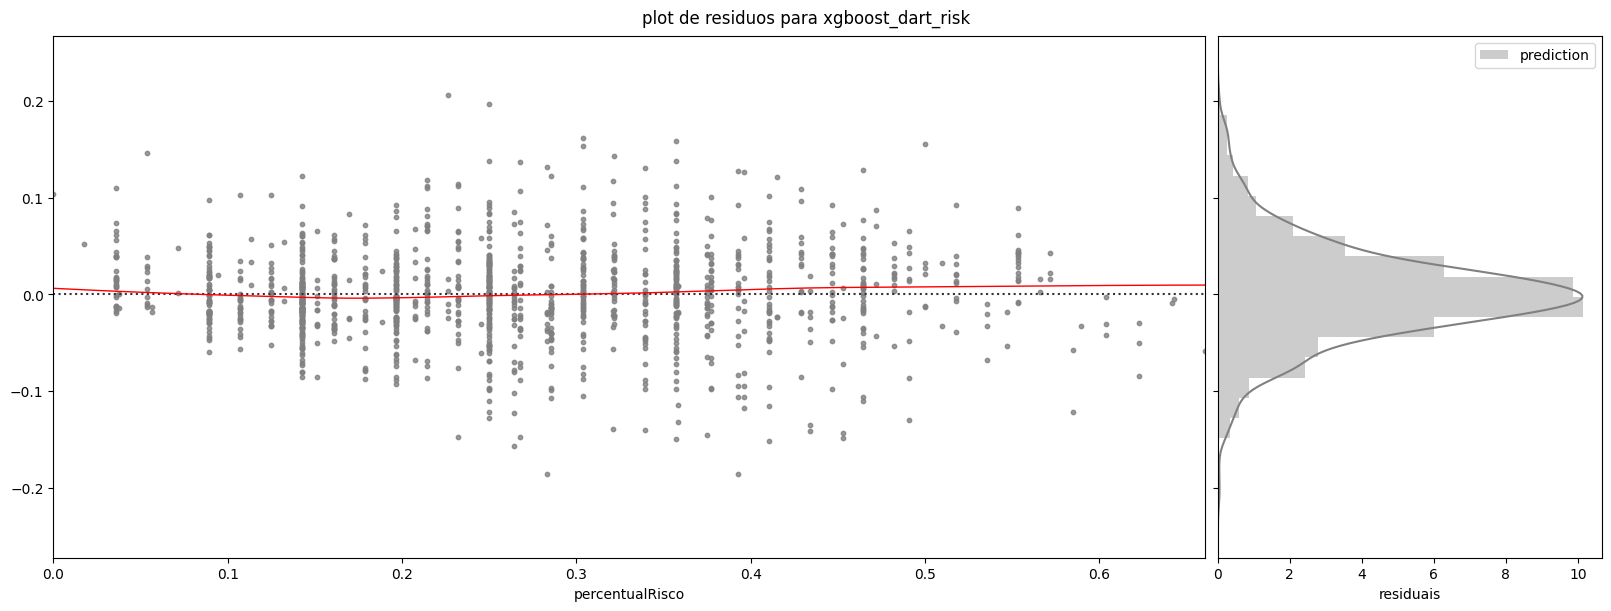

In [19]:
models = [elasticnet_model, random_forests_model, xgboost_model_gbtree, xgboost_model_dart]

# compara os resultados entre os modelos
results = pd.DataFrame()
for model in models:
	validation = pd.DataFrame(model['metrics']['validation'], index=[[model['description']], ['validation']])
	test = pd.DataFrame(model['metrics']['test'], index=[[model['description']], ['test']])
	results = pd.concat([results, pd.concat([validation, test], axis=0)])

display (results)
# plota os graficos de residuais
for model in models:
	# plot_residuals(targets_test, model['estimator'].predict(data_test), model['description'])
	plot_residuals_distribution(targets_test, model['estimator'].predict(data_test), model['description'])

⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
O modelo de regressão xgboost apresentou bom desempenho com um MAE de 3,7% no dataset de teste
</td></tr></table></div>

#### importância das features

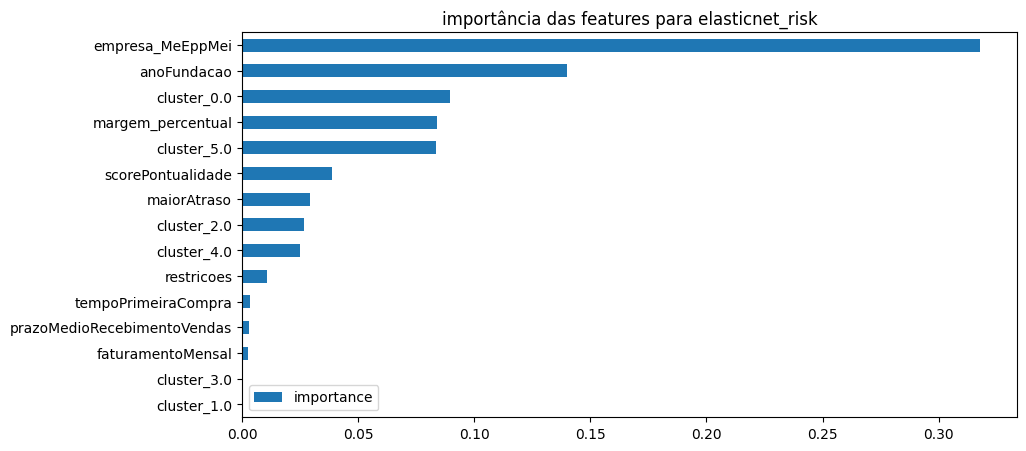

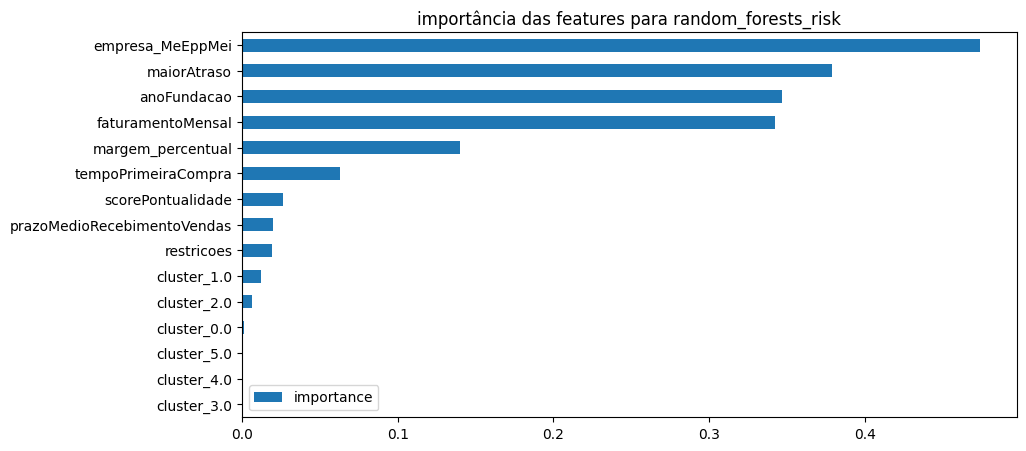

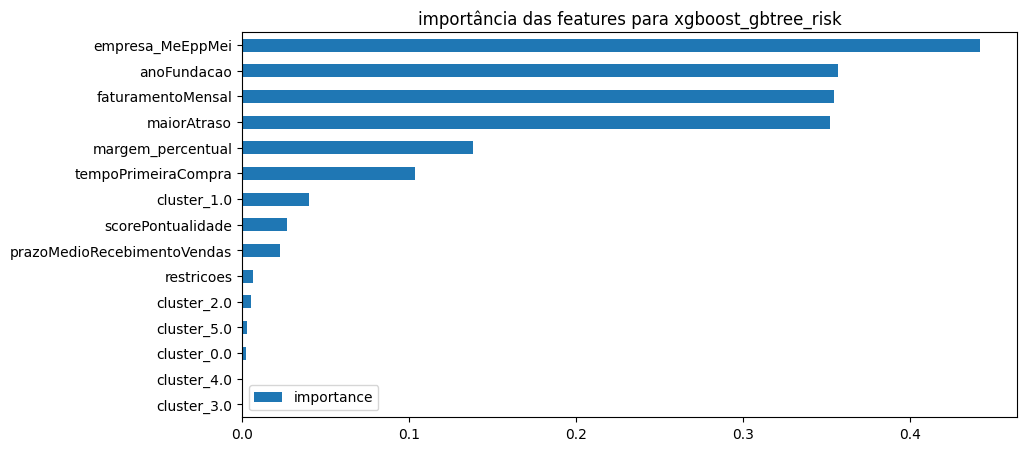

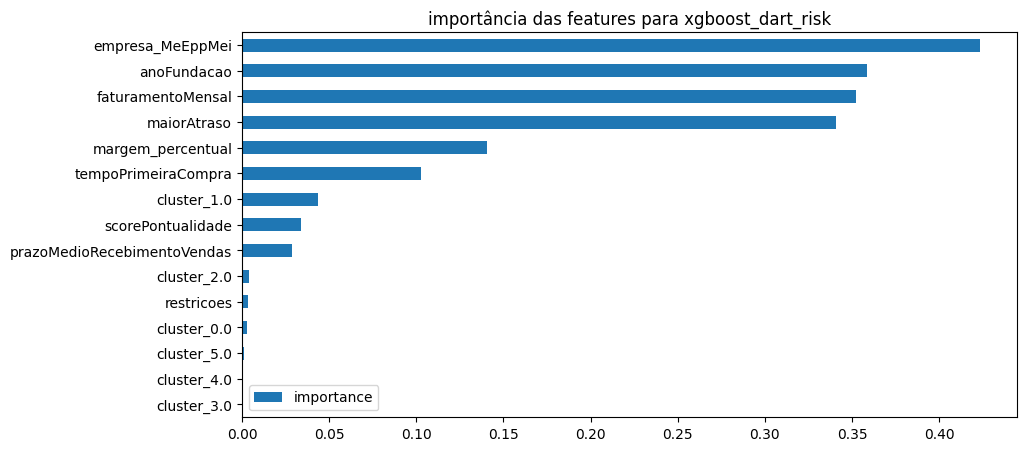

In [20]:
def plot_feature_importances(
		model: dict,
		X: pd.DataFrame,
		y: pd.DataFrame,
		) -> None:
	importances = permutation_importance(model['estimator'], X, y, n_repeats=10)
	table = pd.DataFrame(importances.importances_mean, index=X.columns, columns=['importance'])
	table.sort_values(by='importance', ascending=True, inplace=True)
	table.plot.barh(figsize=(10, 3+int(table.shape[0]/6)))
	plt.title(f"importância das features para {model['description']}")
	plt.show()

for model in models:
	plot_feature_importances(model, data_train, targets_train)


### Conclusão

⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
- O modelo xgboost performou com um erro médio absoluto de ~ 3.7%, sendo um modelo viável para a estimativa de risco em novas contas <br>
- É possível observar que o modelo aproveitou bem as features disponíveis, mas que não levou diretamente em consideração a segmentação de clientes previamente realizada
</td></tr></table></div>